In [1]:
%matplotlib inline

import numpy as np
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate
import scipy.integrate as integrate
import types
# Used for function fitting
import lmfit

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'white'
np.set_printoptions(precision=15)

# Helper functions

In [19]:
def sig_to_fwhm(sig):
    return sig * (2 * np.sqrt(2 * np.log(2)))
def fwhm_to_sig(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    current = minWl
    i = 0
    while current <= maxWl:
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
        current += period
        i = i + 1
    return result

# Classes that define simulated instruments.

In [30]:
class Spectrograph:
    def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
        self.xres = xres
        self.nOrders = nOrders
        self.orderSize = orderSize
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.minWl = minWl
        self.maxWl = minWl + orderSize * nOrders
        self.psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.precision = precision
        self.fac = self.xres / self.orderSize # Constantly used in conversions
        self.blaze = blaze
        
        # Calculate the bootstrap errors of each order
        startWls = self.minWl + (np.arange(0, self.nOrders) * self.orderSize) 
        self.bstrap_errs = np.random.normal(0, startWls * fwhm_to_sig(50) / 3e8)
                                            
    # A spectrograph can observe many beams: a beam is a mapping of wavelength (in nm) to intensity
    
    def blaze_order(self, wlSpace, obs, fsr, mid):
        sigma = fsr / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        return obs * np.exp(-(wlSpace - mid) ** 2 / (2.0 * sigma ** 2)) 
    
    def bstrap_space(self, orders='all'):
        bstrap_space = np.empty((self.nOrders, self.xres,))
        
        if orders == 'all':
            orders = range(0, self.nOrders)
            
        for i in orders:
            startWl = self.minWl + (i * self.orderSize)
            endWl = startWl + self.orderSize
            bstrap_space[i] = np.linspace(startWl, endWl, self.xres, endpoint=False) + self.bstrap_errs[i]
            
        return bstrap_space
    
    def observe(self, beams, orders='all'):
        space = np.empty((self.nOrders, self.xres,))
        observation = np.empty((self.nOrders, self.xres,))
        
        if orders == 'all':
            orders = range(0, self.nOrders)
        
        for i in orders:
            startWl = self.minWl + (i * self.orderSize)
            endWl = startWl + self.orderSize
            fsr = endWl - startWl
            mid = np.mean([startWl, endWl])
            order_space = np.linspace(startWl, endWl, self.xres, endpoint=False)
            order_obs = np.zeros(len(order_space))

            bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, len(order_space)) # Background noise
            bgrNoise[bgrNoise < 0.0] = 0.0001
            order_obs += bgrNoise

            # Each mapping in a beam becomes a gaussian
            for beam in beams:
                for wl in beam:
                    order_obs += gauss(order_space, wl, self.psf_sigma, beam[wl])

            # Add shot noise
            order_obs += np.random.normal(0.0, np.sqrt(order_obs) * self.precision, len(order_space))
            
            # Blaze
            if self.blaze:
                order_obs = self.blaze_order(order_space, order_obs, fsr, mid)
            
#             plt.scatter(order_space, order_obs)
#             plt.show()
            
            space[i] = np.linspace((i * self.xres), ((i + 1) * self.xres) - 1, self.xres)
            observation[i] = order_obs

        return space, observation
    
    def pix_to_wl(self, pix):
        return self.minWl + (pix / self.fac)
        
    def wl_to_pix(self, wl):
        return (wl - sgraph.minWl) * self.fac
        
class LFC:
    def __init__(self, intensity, minWl, maxWl, dWl):
        self.intensity = intensity
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current <= self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self):
        sim = {}
        current = self.minWl
        while current <= self.maxWl:
            sim[current] = self.intensity
            current += self.dWl
        return sim

[  399.   409.   419.   429.   439.   449.   459.   469.   479.   489.
   499.   509.   519.   529.   539.   549.   559.   569.   579.   589.
   599.   609.   619.   629.   639.   649.   659.   669.   679.   689.
   699.   709.   719.   729.   739.   749.   759.   769.   779.   789.
   799.   809.   819.   829.   839.   849.   859.   869.   879.   889.
   899.   909.   919.   929.   939.   949.   959.   969.   979.   989.
   999.  1009.  1019.  1029.  1039.  1049.  1059.  1069.  1079.  1089.
  1099.  1109.  1119.  1129.  1139.  1149.  1159.  1169.  1179.  1189.]
[ -3.580723268501370e-05  -6.518594697331422e-05   1.200966792263469e-05
  -1.863817349247330e-05   5.630865243494960e-05   9.442262598979952e-06
   9.849021996043135e-06  -4.511834992312797e-05  -3.718022856336088e-05
   1.495267304883188e-05   2.113782770720199e-05   9.105073723821322e-06
   8.742199108970849e-06   1.501036551480660e-05  -4.045982496161281e-06
   6.181715668865455e-05   5.369843727364050e-05   2.3967662419098

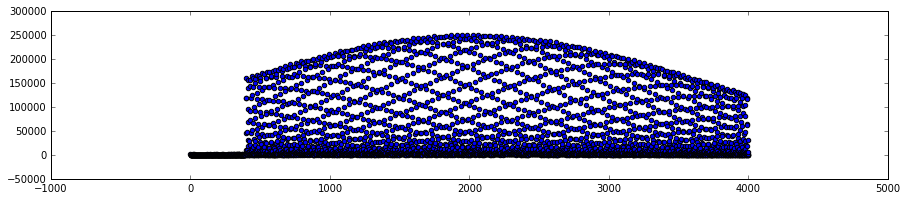

In [29]:
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
lfc = LFC(250000, 400, sgraph.maxWl - 1, 11/347.0)
orders=[0]
xs, ys = sgraph.observe([lfc.simulate()], orders=orders)
plt.scatter(xs[0], ys[0])
# plt.xlim(1000, 1050)

# Finding maxima

In [40]:
def get_peaks(shift, sgraph, lfc, n, mode='wl'):
    if mode == 'wl':
        diff = lfc.dWl
    elif mode == 'pix':
        diff = lfc.dWl * sgraph.fac
    else:
        print('Bad mode in peaks')
        return 'error'
    peaks = np.zeros(n)
    current = shift
    for i in range(0, n):
        peaks[n] = current
        current += diff
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = np.mean(np.abs(y - pred_y))
    error = np.abs(solution - prediction) / solution * 3e8
    return lse, error
    
def guess_min(x, y):
    guess_x = x[y > 2000]
    guess_y = y[y > 2000]
    max_idx = signal.argrelextrema(guess_y, np.greater, order=10)
    guess_max_x = guess_x[max_idx]
    guess_max_y = guess_y[max_idx]
    guess_x = guess_max_x[0]
    guess_y = guess_max_y[0]
    return guess_x, guess_y

def plot_fit(sgraph, lfc, x, y, ss_x, ss_y, y_pred, guess_x, pred_shift_wl):
    plt.figure(1)
#     plt.scatter(ss_x, ss_y, color='magenta', marker='o', facecolors='none')
    plt.scatter(x, y, color='blue', marker='o', facecolors='none')
    plt.plot(ss_x, y_pred, color='red')
    pred_peaks = sgraph.wl_to_pix(get_peaks(pred_shift_wl, sgraph, lfc, len(lfc.getPeaks())), mode='wl')
#     for peak in pred_peaks:
#         plt.axvline(peak, color='green')
#     for peak in lfc_peaks:
#         plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='purple')
    plt.ylim(-100000,800000)
#     plt.axvline(guess_x, color='green')
    plt.xlim(sgraph.wl_to_pix(lfc.minWl - 2 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 8 * lfc.dWl))
#     plt.xlim(3900, 4000)
#     plt.savefig('../figs/fitted.png')
    plt.show()

In [6]:
def find_lfc_peaks(sgraph, lfc, interpolate, output=True, plot=True, order_model=None):
    lfc_peaks = lfc.getPeaks()
    
    if order_model == None:
        def order_model(wl, minWl):
            maxWl = minWl + (len(lfc_peaks) * lfc.dWl * sgraph.fac)
            result = per_gauss(wl, sgraph.psf_sigma * sgraph.fac, minWl, maxWl, lfc.dWl * sgraph.fac, lfc.intensity)
            if sgraph.blaze:
                sigma = sgraph.xres / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
                result = result * np.exp(-(wl - (sgraph.xres / 2)) ** 2 / (2.0 * sigma ** 2)) 
            return result
    
    if output:
        print('Solution is: {}pix or {}nm'.format(sgraph.wl_to_pix(lfc.minWl), lfc.minWl))

    xs, ys = sgraph.observe([lfc.simulate()], orders=[0])
    x = xs[0]
    y = ys[0]
    
    if interpolate:
        # Do a cubic interpolation of x and y 
        spl = scipy.interpolate.UnivariateSpline(x, y, k=3)
        # ss stands for supersampled
        ss_x = np.linspace(0, sgraph.xres, 20000, dtype=np.float64)
        ss_y = spl(ss_x)
    else:
        ss_x = x
        ss_y = y
        
    ss_y[ss_y <= 0.0] = 1e-15
    
    # Fit on interpolated data
    guess_x, guess_y = guess_min(ss_x, ss_y)
    if output:
        print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
    
    # Use lmfit for fitting
    gmod = lmfit.Model(order_model)
    result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='lbfgsb', weights=1/np.sqrt(ss_y),
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
#     result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='leastsq', weights=1/np.sqrt(ss_y),
#                       options={'disp': True, 'xtol': 1e-20, 'ftol': 1e-20, 'maxiter':20000000, 'maxfev':200000})
    pred_shift = result.params['minWl'].value
    y_pred = result.best_fit
    nfev = result.nfev
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    
    if output:
        print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
        print('Number of calls: {}'.format(nfev))
    
#     pred_peaks = get_peaks(pred_shift_wl, lfc, len(lfc_peaks))
    
    lse, error = pred_error(ss_y, y_pred, lfc.minWl, pred_shift_wl)
    if output:
        print('Least squares error is {}'.format(lse))
        print('Error is: {}m/s'.format(error))
    
    if plot:
        plot_fit(sgraph, lfc, x, y, ss_x, ss_y, y_pred, guess_x, pred_shift_wl)
    
    return ss_x, ss_y, pred_shift, lse, error

In [7]:
rand = np.random.random(1)[0]
SNR = 1000
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(SNR ** 2, 400 + rand, 430 + rand, 1/31.0)

Solution is: 498.749748576pix or 400.246874371nm
Initial guess for shift is: [ 498.824941247062384]pix or 400.247062353nm
 - Adding parameter "minWl"
Predicted shift is: [ 496.374109048454955]pix or 400.240935273nm
Number of calls: 47
Least squares error is 236968.313766
Error is: 4451.57666381m/s


/usr/lib/python2.7/site-packages/lmfit/model.py:459: UserWarning: The keyword argument options does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


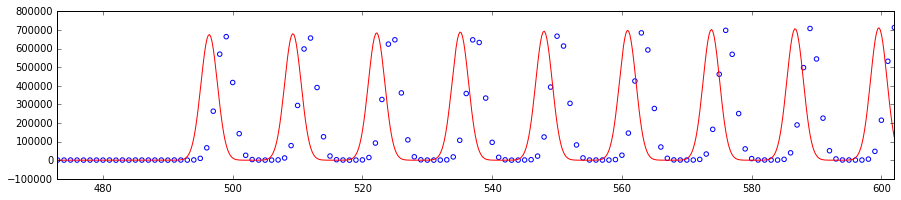

CPU times: user 19.5 s, sys: 16.7 ms, total: 19.5 s
Wall time: 19.5 s


In [8]:
%%time
interpolate = True
# def model(wl, minWl):
#     lfc_peaks = lfc.getPeaks()
#     maxWl = minWl + (len(lfc_peaks) * lfc.dWl * sgraph.fac)
#     result = per_gauss(wl, sgraph.psf_sigma * sgraph.fac + 1.1, minWl, maxWl, lfc.dWl * sgraph.fac, lfc.intensity)
#     if sgraph.blaze:
#         sigma = sgraph.xres / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
#         result = result * np.exp(-(wl - (sgraph.xres / 2)) ** 2 / (2.0 * sigma ** 2)) 
#     return result
find_lfc_peaks(sgraph, lfc, interpolate)

In [9]:
%%time
# Make a plot of error to SNR
def sensitivity(sgraph, lfc, attr, nReps, rang, tol=6, **kwargs):
    x = np.zeros(len(rang))
    y = np.zeros((len(rang), nReps))
    print('Running %d times for each value in %s' % (nReps, rang))
    for i, val in enumerate(rang):
        print('Run %d with %f %s' % (i, val, attr))
        if hasattr(lfc, attr):
            setattr(lfc, attr, val)
        elif hasattr(sgraph, attr):
            setattr(sgraph, attr, val)
        else:
            print('Error, bad attribute')
            return
        x[i] = val
        for j in range(0, nReps):
            err = tol
            while err >= tol:
                _, _, _, _, err = find_lfc_peaks(sgraph, lfc, True, **kwargs)
            y[i][j] = err
    return x,y

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


# SNR sensitivity plot

In [ ]:
%%time
rand = np.random.random(1)[0]
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
lfc = LFC(1000000, 400 + rand, 430 + rand, 0.03)

# rang = [10000, 40000, 90000, 160000, 250000, 360000]
# rang = [490000, 640000, 810000, 1000000]
rang = [200 ** 2, 400 ** 2, 600 ** 2, 800 ** 2, 1000 ** 2]
print(rang)
snr_plot_axis, snr_plot_data = sensitivity(sgraph, lfc, 'intensity', 20, rang, output=True, plot=False)
plt.boxplot(np.transpose(snr_plot_data), labels=np.char.mod('%f', np.sqrt(snr_plot_axis)))
plt.show()
%store snr_plot_axis
%store snr_plot_data

In [ ]:
plt.figure(1, figsize=(10,3))
plt.boxplot(np.transpose(snr_plot_data), labels=np.char.mod('%.1f', np.sqrt(snr_plot_axis)))
plt.ylabel('Error in m/s')
plt.xlabel('SNR')
ax = plt.subplot(111)
ax.set_yscale('log')
plt.ylim(1e-4, 1e1)
plt.axhline(0.1, color='black', linestyle='dashed')
plt.figtext(0.6, 0.35, 'Goal precision', size='xx-large')
plt.savefig('../figs/snrverr.png')

# PSF stability sensitivity plot

In [ ]:
%%time
rand = np.random.random(1)[0]
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(1000000, 400 + rand, 430 + rand, 0.03)


rang = [(0.0075 + (0.0025 / 10)) / (2 * np.sqrt(2 * np.log(2))), 
        (0.0075 + (0.0025 / 25)) / (2 * np.sqrt(2 * np.log(2))),
        (0.0075 + (0.0025 / 50)) / (2 * np.sqrt(2 * np.log(2))),
        (0.0075 + (0.0025 / 100)) / (2 * np.sqrt(2 * np.log(2)))]
print(rang)
model_sigma = sgraph.psf_sigma * sgraph.fac
def model(wl, minWl):
    lfc_peaks = lfc.getPeaks()
    maxWl = minWl + (len(lfc_peaks) * lfc.dWl * sgraph.fac)
    result = per_gauss(wl, model_sigma, minWl, maxWl, lfc.dWl * sgraph.fac, lfc.intensity)
    if sgraph.blaze:
        sigma = sgraph.xres / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        result = result * np.exp(-(wl - (sgraph.xres / 2)) ** 2 / (2.0 * sigma ** 2)) 
    return result

psf_plot_axis, psf_plot_data = sensitivity(sgraph, lfc, 'psf_sigma', 20, rang, tol=10, plot=True, output=True, order_model=model)
plt.boxplot(np.transpose(psf_plot_data), labels=np.char.mod('%e', np.arange(2.7, 3.31, 1/10.0)))
plt.show()
%store psf_plot_axis
%store psf_plot_data

In [ ]:
plt.figure(1, figsize=(10,3))
plt.boxplot(np.transpose(psf_plot_data), labels=np.char.mod('%.2f', np.asarray([3.1, 3.04, 3.02, 3.01])))
plt.xlabel('Full width at half maximum of simulated PSF')
plt.ylabel('Error in m/s')
plt.savefig('../figs/stabverr.png')
# Add some more points, in range 1/10th pixel. Maybe (0.5, 0.1, 0.01), something like that

# Correlation of residuals with shift difference

In [ ]:
%%time
rand = np.random.random(1)[0]
SNR = 1000
n = 100
tol = 100.0
lses = np.zeros(n)
errors = np.zeros(n)
for i in range(0, n):
    print('Run %d:' % (i))
    # def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
    sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
    # def __init__(self, intensity, minWl, maxWl, dWl):
    lfc = LFC(SNR ** 2, 400 + rand, 430 + rand, 1/31.0)
    interpolate = True
    error = tol + 1
    while error >= tol:
        _, _, _, lse, error = find_lfc_peaks(sgraph, lfc, interpolate, output=True, plot=False)
    lses[i] = lse
    errors[i] = error
%store lses
%store errors
plt.scatter(errors, lses)

 - Adding parameter "m"
 - Adding parameter "b"
[[Model]]
    Model(fit)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 100
    # variables        = 2
    chi-square         = 3886.389
    reduced chi-square = 39.657
[[Variables]]
    m:   6.90523751 +/- 4.963468 (71.88%) (init= 1)
    b:   1201.52097 +/- 1.897585 (0.16%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(m, b)                      = -0.943 

      99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 m: -15.10739  -9.84998  -4.89976   6.90524  +4.89949  +9.84983 +15.10724
 b:  -5.77068  -3.74239  -1.866981201.52098  +1.86703  +3.74244  +5.77016
m: 6.905238, b: 1201.520976


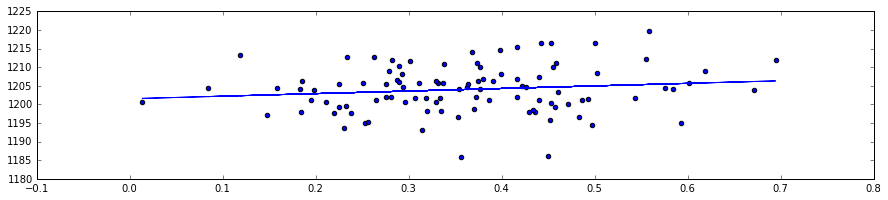

In [25]:
def fit(x, m, b):
    return m*x+b
gmod = lmfit.Model(fit)
result = gmod.fit(lses, x=errors, m=1, b=0, method='leastsq', options={})
print(result.fit_report())
print(result.ci_report())
preds = result.best_fit
plt.scatter(errors, lses)
plt.plot(errors, preds)
m = result.params['m'].value
b = result.params['b'].value
print('m: %f, b: %f' % (m, b))


In [ ]:
plt.hist(lses)

# Assigning wavelengths to pixels

Solution is: 769.019984365pix or 400.922549961nm
Initial guess for shift is: [ 769.038451922596209]pix or 400.92259613nm
 - Adding parameter "minWl"
Predicted shift is: [ 768.020494926843639]pix or 400.920051237nm
Number of calls: 15
Least squares error is 104184.626694
Error is: 1869.73039814m/s


IndexError: index 930 is out of bounds for axis 0 with size 930

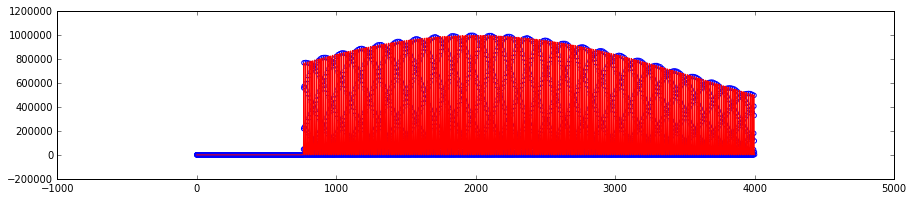

In [41]:
rand = np.random.random(1)[0]
interpolate = True
SNR = 1000
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(SNR ** 2, 400 + rand, 430 + rand, 1/31.0)
x, y, pred_shift, _, _ = find_lfc_peaks(sgraph, lfc, interpolate)
pred_shift_wl = sgraph.pix_to_wl(pred_shift)
peaks = get_peaks(pred_shift, sgraph, lfc, len(lfc.getPeaks()), mode='pix')
bstrap_space = sgraph.bstrap_space(orders=[0])

plt.scatter(x, y)
for peak in peaks:
    plt.axvline(peak)
plt.show()

# Notes
**For future**:
- Make a table of effect of increasing the lfc intensity
- Create plot of jitter to error
- Resolution = wl of order / (wl to pix ratio) -> 400 / 0.025
- 80 orders [pix, intens, order]
- Further away orders are distorted
- Should use adjacent order
- Generate plots of SNR to error in cm/s
    - Moving Sigma from 2 to 4, R from 50,000 to 20,0000
- Paper submission to PASP

**Open questions**:
- Spectrograph error distribution: what is a good mean and a mean sdev?
- Doing least squares: should I weight according to error? For example, know error increases with intensity


**Todays notes**:
Stop plot at SNR 500 (intensity 250,000)


**Ask tyler for specs of EXPRESS**
IOP paper guidelines

In [ ]:
plt.boxplot(np.transpose(y), labels=x)
plt.ylim(0,3)
plt.show()

In [ ]:
print(y)

# Using energy instead of SNR directly

In [ ]:
hc = 1.9864458e-25
integ = integrate.quad(lambda wl: gauss(wl, 0, 4, 1), -np.inf, np.inf)
# x = np.linspace(-20, 20, 1000)
# y = gauss(x, 0, 4, 1)
# plt.hist(y, 100)
# plt.plot(x,y)
print(integ[0])
# k = laser_E / photon_energy
laser_e = 12
wl = 400e-9
k = (laser_e / (hc / wl)) / integ[0]
k

# Failed code to use multiple orders in fitting: impossible!

In [ ]:
def find_lfc_peaks_mult_orders(sgraph, lfc, orderId):
    lfc_peaks = lfc.getPeaks()
    
    print('Solution is: {}pix or {}nm'.format(sgraph.wl_to_pix(lfc.minWl), lfc.minWl))

    space, obs = sgraph.observe([lfc.simulate()])
    
    bottom = False
    top = False
    mid = False
    orders = []
    spaces = []
    # Select relevant orders
    if orderId == 0: # If first order in spectrum
        bottom = True
        orders.append(obs[0])
        spaces.append(space[0])
        if len(obs) > 1:
            orders.append(obs[1])
            spaces.append(space[1])
    elif orderId == len(obs) - 1: # else if last
        top = True
        orders.append(obs[-1])
        spaces.append(space[-1])
        if len(obs) > 1:
            orders.append(obs[-2])
            spaces.append(space[-2])
    else: # else middle order
        mid = True
        orders.append(obs[orderId - 1])
        spaces.append(space[orderId - 1])
        orders.append(obs[orderId])
        spaces.append(space[orderId])
        orders.append(obs[orderId + 1])
        spaces.append(space[orderId + 1])
        
    ss_xres = 5 * sgraph.xres
    ss_xs = np.empty((len(orders), ss_xres))
    ss_ys = np.empty((len(orders), ss_xres))
    prev_range = None
    # Interpolate selected orders
    for i in range(0, len(orders)):
        x = spaces[i]
        y = orders[i]
        
        spl = interpolate.UnivariateSpline(x, y, k=3)
        # This is the tricky part. I need the 'distance' between orders, so that I can
        # align them in pixel space correctly. For now, I am assuming that they are adjacent
#         ss_x = np.linspace(order_range[0], order_range[1], ss_xres, dtype=np.float64)
        ss_x = np.linspace(x[0], x[-1], ss_xres)
        ss_y = spl(ss_x)
        ss_y[ss_y <= 0.0] = 1e-15
        
        ss_xs[i] = ss_x
        ss_ys[i] = ss_y
        
    # Paste orders together
    all_ss_x = np.concatenate(ss_xs)
    all_ss_y = np.concatenate(ss_ys)
    
    # Fit on interpolated data
    def per_gauss_fit(wl, shift):
        # per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
        return per_gauss(wl, sgraph.sigma * sgraph.fac, all_ss_x[0] + shift, all_ss_x[-1] + shift, 
                         lfc.dWl * sgraph.fac, lfc.intensity)
    
    def err_func(shift):
        err = 0.0
        # Fit the same per_gauss on each order
        for i in range(0, len(ss_xs)):
            err += np.mean(np.abs(per_gauss_fit(ss_xs[i], shift) - ss_ys[i]))
        return err
        
    guess_x, guess_y = guess_min(ss_xs[0], ss_ys[0])
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
    
    gmod = lmfit.Model(per_gauss_fit)
    # Should weight as well!!
    result = gmod.fit(all_ss_y, wl=all_ss_x, shift=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
    pred_shift = result.params['shift'].value
    all_y_pred = result.best_fit
    nfev = result.nfev
    
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
  
    lse, error = pred_error(all_ss_y, all_y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    plt.scatter(all_ss_x, all_ss_y, color='blue')
    plt.plot(all_ss_x, all_y_pred, color='red')
    plt.axvline(guess_x, color='turquoise')
#     plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
    plt.xlim(7000, 7150)
    fig = plt.show()
    
    return error